In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
# print(os.getcwd())


# Load the dataset
# Replace 'path_to_your_dataset.csv' with the actual path to your dataset
#df = pd.read_csv('/content/merged_data.csv')
df = pd.read_csv('../merged_data.csv')

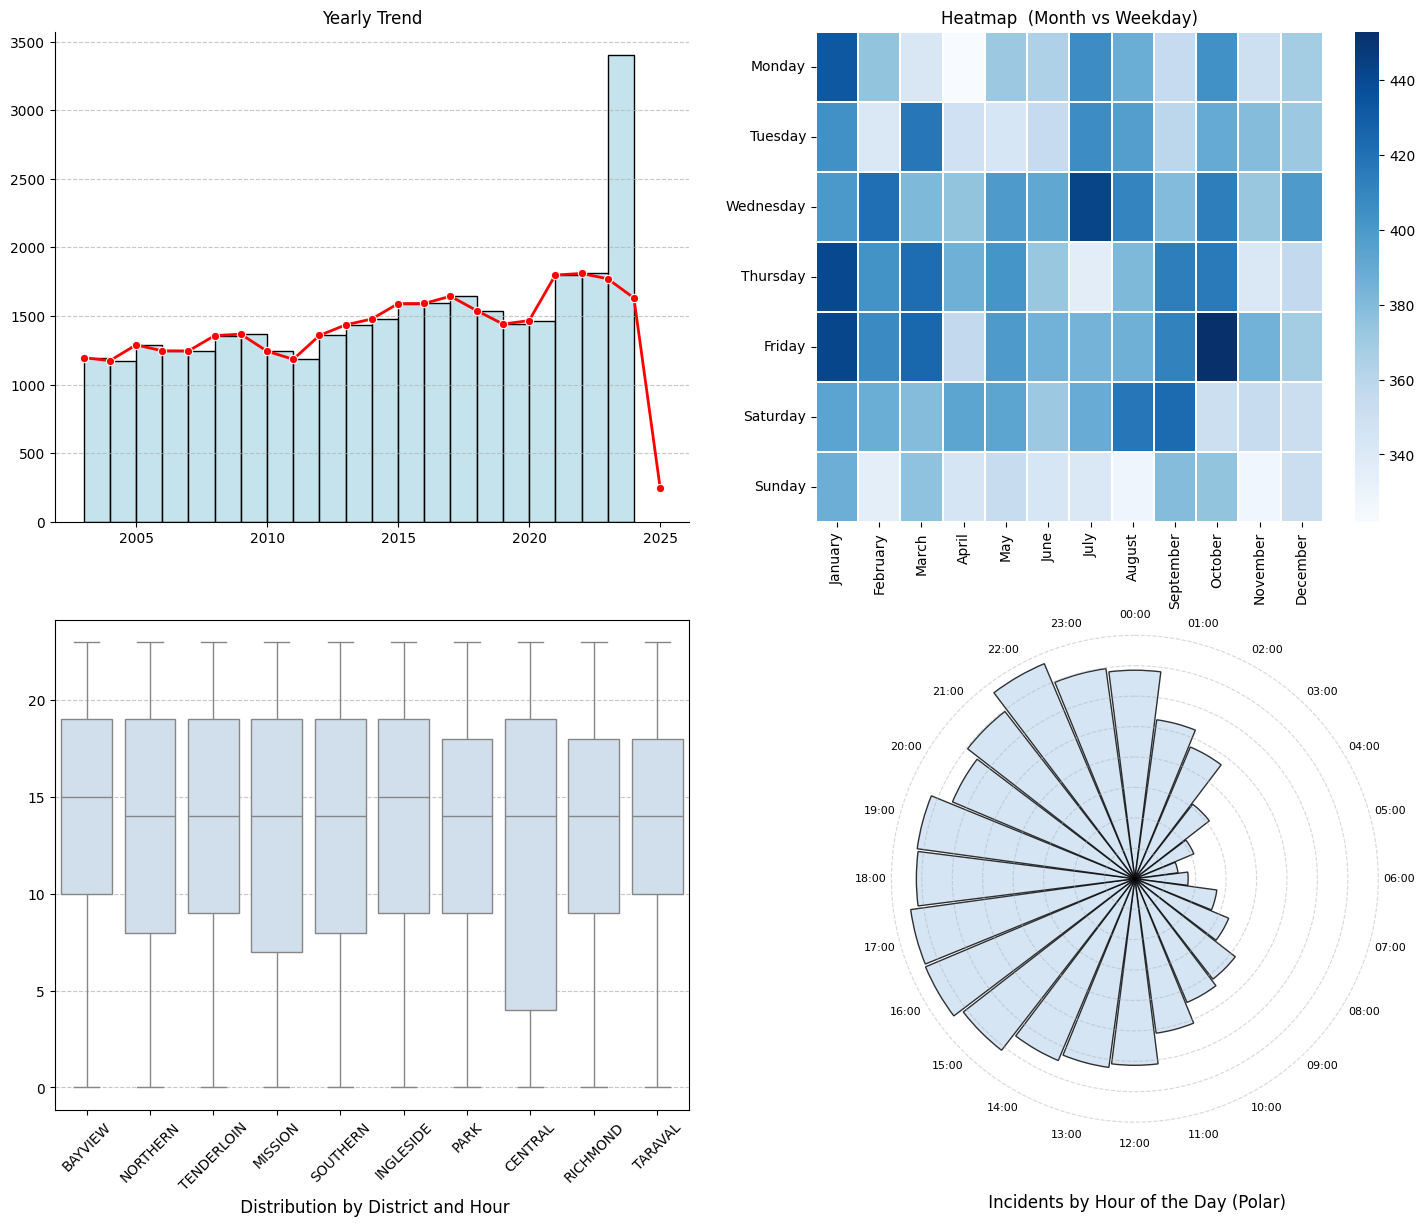

In [8]:
# @title
import warnings
warnings.filterwarnings("ignore", module="matplotlib.font_manager")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the global font
plt.rcParams['font.family'] = 'DejaVu Sans'

#--- DATA PREPARATION ---#

# Clean the dataset
df_clean = df.dropna(subset=['DayOfMonth', 'Month', 'Year']).copy()
weapon_df = df_clean[df_clean['Category'] == 'WEAPON LAWS'].copy()


# Create date column
weapon_df["Date"] = pd.to_datetime(
    weapon_df["DayOfMonth"].astype(int).astype(str) + " " +
    weapon_df["Month"].astype(str) + " " +
    weapon_df["Year"].astype(int).astype(str),
    format="%d %B %Y", errors="coerce"
)
weapon_df.dropna(subset=["Date"], inplace=True)

# Ensure Year is numeric
weapon_df['Year'] = weapon_df['Year'].astype(int)

# Aggregate incidents per year
yearly_counts = weapon_df.groupby('Year').size().reset_index(name='Incidents')

# Prepare data for heatmap
heatmap_data = weapon_df.groupby(['Month', 'DayOfWeek']).size().reset_index(name='Incidents')
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

heatmap_data['Month'] = pd.Categorical(heatmap_data['Month'], categories=month_order, ordered=True)
heatmap_data['DayOfWeek'] = pd.Categorical(heatmap_data['DayOfWeek'], categories=weekday_order, ordered=True)
heatmap_pivot = heatmap_data.pivot(index='DayOfWeek', columns='Month', values='Incidents')

# Prepare hourly data
hourly_counts = weapon_df['TimeOfDay'].value_counts().sort_index()

#--- PLOTTING ---#

# Create subplot layout
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
# Exclude only 2025
weapon_df_sub = weapon_df[weapon_df['Year'] <= 2024]
yearly_counts_sub = yearly_counts[yearly_counts['Year'] <= 2024]
# 1. Yearly Histogram and Trend Line
sns.histplot(data=weapon_df_sub, x='Year', bins=range(weapon_df_sub['Year'].min(), 2025),
#sns.histplot(data=weapon_df, x='Year', bins=range(weapon_df['Year'].min(), weapon_df['Year'].max()+2),
             color='lightblue', edgecolor='black', alpha=0.7, ax=axes[0, 0])
sns.lineplot(data=yearly_counts, x='Year', y='Incidents', marker='o', color='red', linewidth=2, ax=axes[0, 0])
axes[0, 0].set_title('Yearly Trend')
axes[0, 0].set_xlabel('', fontsize=12)
axes[0, 0].set_ylabel('', fontsize=12)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(ax=axes[0, 0])

# 2. Heatmap (Month vs Weekday)
sns.heatmap(heatmap_pivot, cmap='Blues', linewidths=0.3, ax=axes[0, 1])
axes[0, 1].set_title('Heatmap  (Month vs Weekday)', fontsize=12)
axes[0, 1].set_xlabel('', fontsize=12)
axes[0, 1].set_ylabel('', fontsize=12)

# 3. District-wise Hour-of-Day boxplot
sns.boxplot(
    data=weapon_df,
    x='PdDistrict',
    y='TimeOfDay',
    color='#CCDFf1',
    ax=axes[1, 0]
)
#axes[1, 0].set_title('Weapon Law Incident Distribution by District and Hour', fontsize=14)
axes[1, 0].set_xlabel(' Distribution by District and Hour', fontsize=12)
axes[1, 0].set_ylabel('', fontsize=12)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Hour of day histogram
import numpy as np

# --- hourly counts ---
hourly_counts_sorted = hourly_counts.sort_index()
r = hourly_counts_sorted.values
theta = np.linspace(0.0, 2 * np.pi, len(r), endpoint=False)

# --- Remove axes[1,1] and insert a floating polar plot ---
# Step 1: Delete the 4th subplot (axes[1,1]) if created
fig.delaxes(axes[1, 1])

# Step 2: Create a free-standing polar plot on the same figure
polar_ax = fig.add_axes([0.55, 0.1, 0.35, 0.35], projection='polar')  # left, bottom, width, height in figure coordinates

# Step 3: Plot the bars
bars = polar_ax.bar(theta, r, width=0.25, color='#CCDFf1', edgecolor='black', alpha=0.8)

# Make it clean
polar_ax.set_theta_direction(-1)
polar_ax.set_theta_offset(np.pi / 2.0)
polar_ax.set_xticks(theta)
polar_ax.set_xticklabels([f'{h:02d}:00' for h in hourly_counts_sorted.index], fontsize=8)
polar_ax.set_yticklabels([])

# Only circular gridlines
polar_ax.xaxis.grid(False)
polar_ax.yaxis.grid(True, linestyle='--', alpha=0.5)

# Remove the outer frame (works now)
polar_ax.spines['polar'].set_visible(False)
# Add title below the polar plot
fig.text(0.725, 0.04, ' Incidents by Hour of the Day (Polar)', fontsize=12, ha='center')

# Save the figure
output_path = "assets/images"
os.makedirs(output_path, exist_ok=True)
fig.savefig(os.path.join(output_path, "weapon_laws_analysis.png"), dpi=300, bbox_inches='tight')


In [2]:
import plotly.graph_objs as go
import plotly.offline as pyo

fig = go.Figure(data=[go.Scatter(x=[1, 2, 3], y=[3, 1, 6], mode='lines+markers')])
pyo.plot(fig, filename='assets/interactive_plot.html', auto_open=False)

'assets/interactive_plot.html'